In [1]:
import tensorflow as tf
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 20
num_epochs = 150
image_size = 224
auto = tf.data.AUTOTUNE
kfold = 10
seed = 40

In [2]:
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder

def load_data(data_directory):
    images = []
    labels = []
    classes = []
    label_encoder = LabelEncoder()

    for class_name in os.listdir(data_directory):
        class_path = os.path.join(data_directory, class_name) # 각 클래스 디렉터리 경로
        if os.path.isdir(class_path): # 디렉터리인 경우만 취급
            classes.append(class_name) # 클래스 리스트

            for filename in os.listdir(class_path):
                filepath = os.path.join(class_path, filename) # 각각의 이미지 파일 경로
                img = cv2.imread(filepath) # 각각의 이미지 파일 로드
                if img is not None:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # BGR에서 RGB로 변환
                    img = cv2.resize(img, (224, 224)) # 224X224 사이즈로 변환
                    img = img / 255.0 # 픽셀값이 0에서 1사이가 되도록 정규화
                    images.append(img)
                    labels.append(class_name)
    images = np.array(images)
    labels = label_encoder.fit_transform(labels) # 라벨 생성

    return images, labels, classes

data_dir = os.getenv('HOME') + '/aiffel/DL_Thon/jellyfish/Train_Test_Valid_new' # 데이터 부모 디렉터리 경로
# 훈련 데이터셋 로드
train_dir = os.path.join(data_dir, 'Train')
train_images, train_labels, train_classes = load_data(train_dir)

# 검증 데이터셋 로드
valid_dir = os.path.join(data_dir, 'valid')
valid_images, valid_labels, valid_classes = load_data(valid_dir)

# 테스트 데이터셋 로드
test_dir = os.path.join(data_dir, 'test')
test_images, test_labels, test_classes = load_data(test_dir)

jellyfish_classes = {0: 'Barrel', 1: 'Blue', 2: 'Compass', 3: 'Lion’s mane', 4: 'Mauve stinger', 5:'Moon'}

print(f'Training data samples: {len(train_images)}')
print(f'Validation data samples: {len(valid_images)}')
print(f'Test data smaples: {len(test_images)}')

Training data samples: 1813
Validation data samples: 183
Test data smaples: 244


In [3]:
from keras.layers import RandomCrop, RandomRotation, RandomZoom

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 20
num_epochs = 150
image_size = 224
auto = tf.data.AUTOTUNE
seed = 40

# 데이터 증강 리스트 정의
augmentation_layers = [
    RandomCrop(image_size, image_size), # 이미지 영역을 크롭
    RandomRotation(0.2), # 이미지를 최대 20% 랜덤 회전
    RandomZoom(0.2), # 이미지를 최대 20% 축소
#     RandomNoise(0.1), # 이미지에 최대 10% 노이즈 추가
#     BrightnessContrast(0.1), # 이미지 밝기 최대 10% 감소
#     ElasticTransform(alpha=1, sigma=50, alpha_affine=50), # 이미지 변형
]


# 데이터 증강 함수 정의
def augment_images(images):
    for layer in augmentation_layers:
        images = layer(images, training=True)
    return images


def make_datasets(images, labels, is_train=False):
    # 매개변수로 전달되는 이미지와 레이블로 데이터프레임 생성
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(batch_size * 10) # 학습 데이터일 경우에만 배치 사이즈*10의 단위로 셔플
    dataset = dataset.batch(batch_size)
    if is_train:
        dataset = dataset.map(
            lambda x, y: (augment_images(x), y), num_parallel_calls=auto # 학습 데이터일 경우에만 데이터 증강
        )
    return dataset.prefetch(auto)


train_dataset = make_datasets(train_images, train_labels, is_train=True)
val_dataset = make_datasets(valid_images, valid_labels)
test_dataset = make_datasets(test_images, test_labels)

train_dataset # 학습 데이터에 대한 데이터프레임 확인

<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>

In [4]:
import keras
from keras.layers import Activation, Conv2D, DepthwiseConv2D, Add, Rescaling, GlobalAvgPool2D, Dense, BatchNormalization

# 활성화 계층 함수 정의 - 활성화함수: ReLU
def activation_block(x):
    x = Activation("relu")(x)
    return BatchNormalization()(x) # 활성화 계층 통과 시, 배치 정규화 진행

# 합성곱 계층 함수 정의
def conv_stem(x, filters: int, patch_size: int):
    x = Conv2D(filters, kernel_size=patch_size, strides=patch_size)(x)
    return activation_block(x) # 합성곱 계층 통과 시, 활성화 계층으로 이동

# ConvMixer 계층 함수 정의
def conv_mixer_block(x, filters: int, kernel_size: int):
    x0 = x
    x = DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x)
    x = Add()([activation_block(x), x0]) # Skip connection 진행

    x = Conv2D(filters, kernel_size=1)(x)
    x = activation_block(x)

    return x

# 모델 정의
def get_conv_mixer_256_8(
    image_size=image_size, filters=128, depth=8, kernel_size=3, patch_size=3, num_classes=6
):
    inputs = keras.Input((image_size, image_size, 3)) # Input 계층
    x = Rescaling(scale=1.0 / 255)(inputs) # 데이터 정규화 진행
    x = conv_stem(x, filters, patch_size) # 합성곱 계층

    for _ in range(depth):
        x = conv_mixer_block(x, filters, kernel_size) # 설정한 깊이만큼 ConvMixer 계층 생성

    x = GlobalAvgPool2D()(x) # 이 전 계층의 출력을 1차원 벡터로 변환
    outputs = Dense(num_classes, activation="softmax")(x) # 완전 연결 계층

    return keras.Model(inputs, outputs)

In [5]:
from tensorflow_addons.optimizers import AdamW
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 모델 학습 함수 정의
def run_experiment(ver, model):
    
    # 옵티마이져: AdamW - 학습률, 가중치 감소 지정
    optimizer = AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # 모델 컴파일
    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    checkpoint_filepath = f"./checkpoint_convmixer_ver{ver}.keras" # 최적화 성능 모델 저장 경로 설정
    checkpoint = ModelCheckpoint(
        checkpoint_filepath, # 모델 저장 경로
        monitor="val_accuracy", # 저장 조건
        save_best_only=True, # 최적화 모델 저장 여부
        save_weights_only=True, # 가중치 포함 여부
    )
    # 조기종료 조건 설정
    early_stopping = EarlyStopping(patience=10, monitor='val_loss', verbose=1, restore_best_weights=True)

    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=num_epochs,
        callbacks=[early_stopping, checkpoint],
    )

#     model.load_weights(checkpoint_filepath)
    results = model.evaluate(test_dataset)
    
    print("Test Loss:", results[0])
    print("Test Accuracy:", results[1])

    return history, model

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_result(history):
    sns.set(style="whitegrid")

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    
    plt.figure(figsize=(12, 6))

    # Accuracy 그래프
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs_range, y=acc, label='Train Accuracy', color='blue')
    sns.lineplot(x=epochs_range, y=val_acc, label='Val Accuracy', color='red')
    plt.title('Train & Val Accuracy')
    plt.legend()

    # Loss 그래프
    plt.subplot(1, 2, 2)
    sns.lineplot(x=epochs_range, y=loss, label='Train Loss', color='blue')
    sns.lineplot(x=epochs_range, y=val_loss, label='Val Loss', color='red')
    plt.title('Train & Validation Loss')
    plt.legend()

    plt.show()

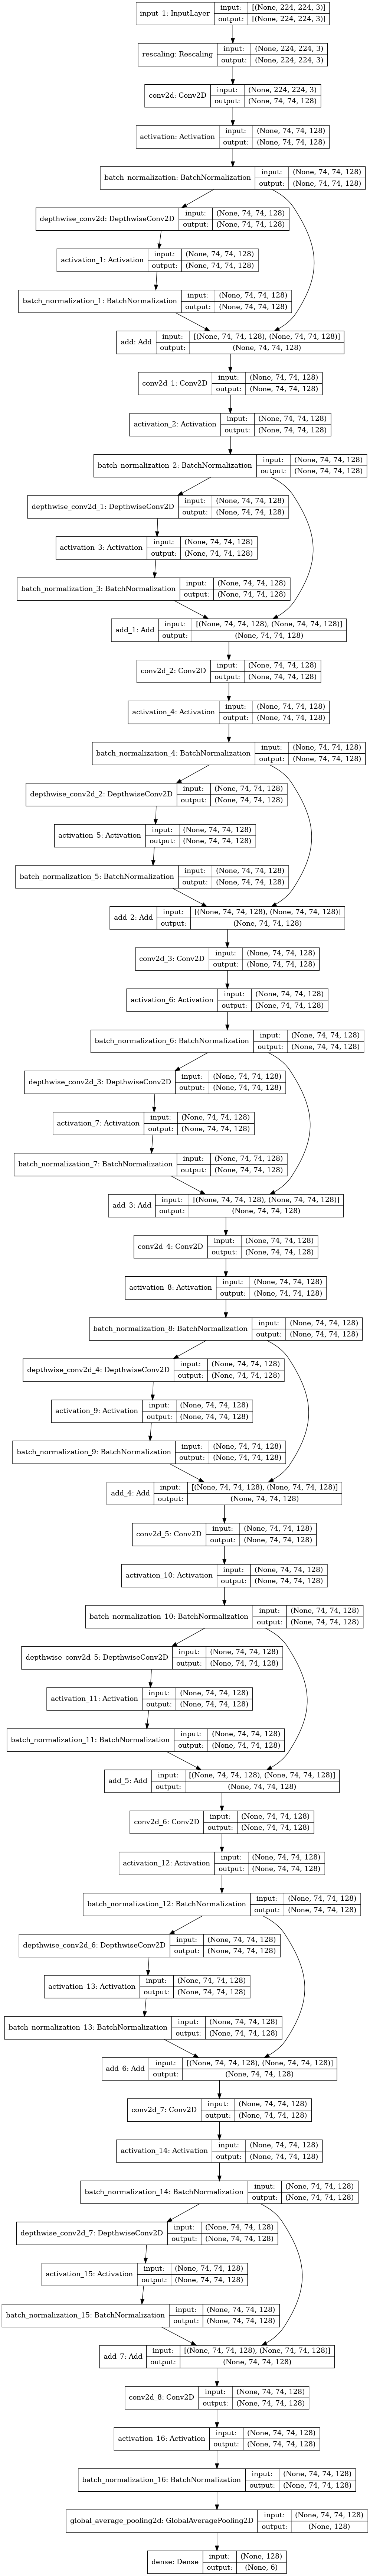

In [7]:
from tensorflow import keras

# 모델 생성
model = get_conv_mixer_256_8()

# 모델 구조 확인
keras.utils.plot_model(model, show_shapes=True, expand_nested=True)

In [8]:
# 모델 학습
history, conv_mixer_model = run_experiment(2, model)

Epoch 1/150
91/91 [==============================] - 31s 274ms/step - loss: 1.7171 - accuracy: 0.4346 - val_loss: 1.7209 - val_accuracy: 0.1967
Epoch 2/150
91/91 [==============================] - 25s 268ms/step - loss: 1.7132 - accuracy: 0.3971 - val_loss: 1.8923 - val_accuracy: 0.1967
Epoch 3/150
91/91 [==============================] - 25s 272ms/step - loss: 1.7056 - accuracy: 0.3685 - val_loss: 1.8373 - val_accuracy: 0.1967
Epoch 4/150
91/91 [==============================] - 26s 279ms/step - loss: 1.7006 - accuracy: 0.3718 - val_loss: 1.8758 - val_accuracy: 0.1967
Epoch 5/150
91/91 [==============================] - 26s 276ms/step - loss: 1.7077 - accuracy: 0.3607 - val_loss: 1.9424 - val_accuracy: 0.1967
Epoch 6/150
91/91 [==============================] - 25s 273ms/step - loss: 1.7152 - accuracy: 0.3635 - val_loss: 1.7334 - val_accuracy: 0.3115
Epoch 7/150
91/91 [==============================] - 26s 283ms/step - loss: 1.6904 - accuracy: 0.3354 - val_loss: 1.7301 - val_accuracy:

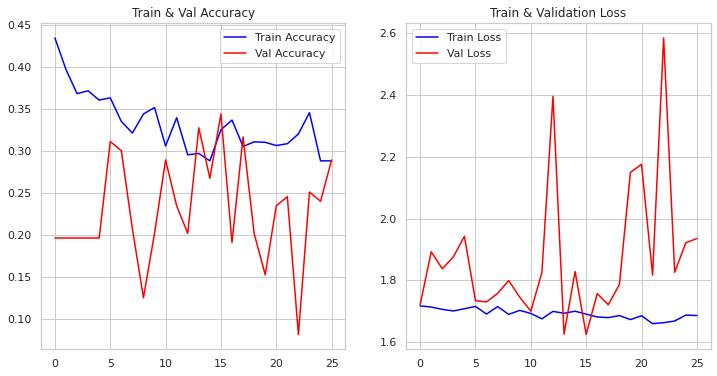

In [9]:
# 학습 결과를 시각화
visualize_result(history)

In [11]:
result = model.evaluate(test_dataset)
print('Test Loss: {0:.3f}'.format(result[0]))
print('Test Accuracy: {0:.3f} %'.format(result[1]*100))

13/13 [==============================] - 1s 53ms/step - loss: 1.6462 - accuracy: 0.2746
Test Loss: 1.646
Test Accuracy: 27.459 %
